In [2]:
# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier

/usr/local/Caskroom/miniconda/base/envs/ufo-prediction/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
%load_ext autoreload
%autoreload 2

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [19]:
!git lfs pull

In [15]:
DATA_DIR = os.path.join('.')

path_data_NLD = os.path.join(DATA_DIR, 'df-NLD-exp.pkl')
path_data_FRA = os.path.join(DATA_DIR, 'df-FRA-exp.pkl')
path_data_ESP = os.path.join(DATA_DIR, 'df-ESP-exp.pkl')

df = pd.read_pickle(path_data_NLD)


## Preprocessing

## Experiments

#### Default params

In [16]:
xgb_model_params = {'tree_method': 'hist'}
xgb_hyperparams = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

### Regression

2022-10-21 16:25:38,756 | ERROR : Failed to calculate energy error: [Errno 2] No such file or directory: '/p/projects/eubucco/data/3-ml-inputs/TABULA_heating_demand.csv'


MAE: 10.73 y
RMSE: 16.85 y
R2: 0.5483
R2: nan
MAPE: nan


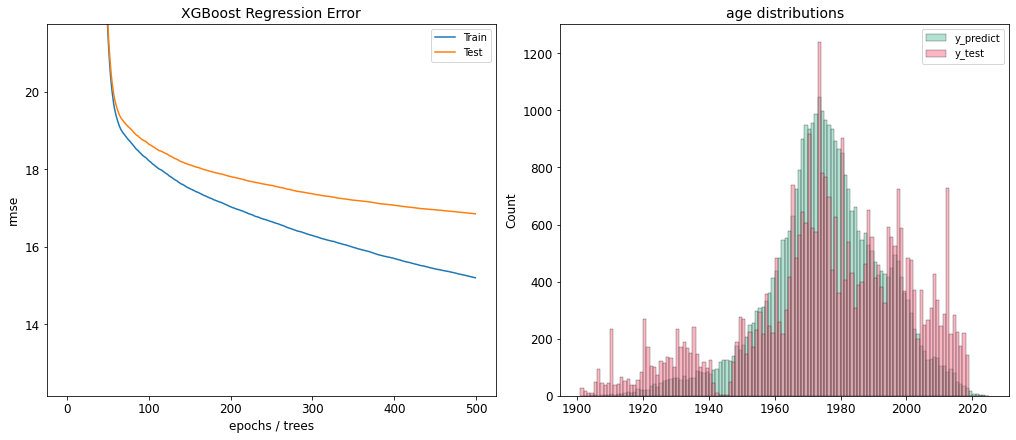

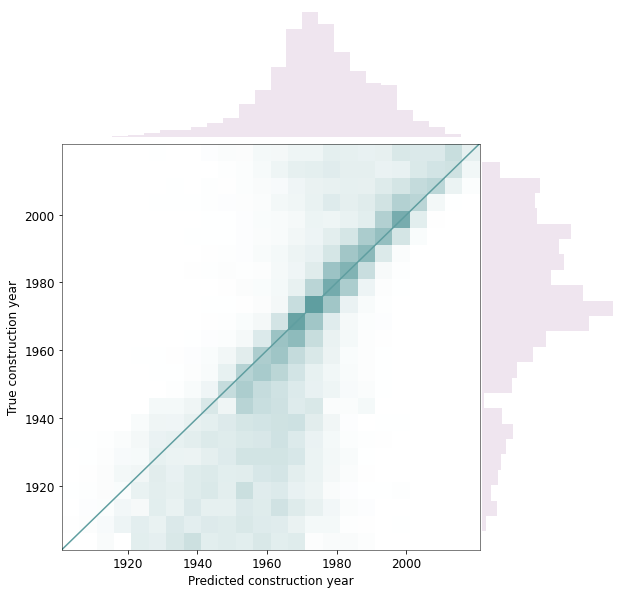

In [20]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    preprocessing_stages=[pp.remove_outliers]
)

predictor.evaluate()


#### Classification

2022-11-01 09:55:47,383 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-01 09:55:47,384 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']
2022-11-01 09:55:47,598 | INFO : Dataset length: 176319
2022-11-01 09:55:47,603 | INFO : Dataset allocated memory: 184 MB
2022-11-01 09:55:47,780 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-478afd1e.abort.
2022-11-01 09:55:47,781 | INFO : Training dataset length: 141055
2022-11-01 09:55:47,782 | INFO : Test dataset length: 35264
2022-11-01 09:55:47,785 | INFO : Test cities: ['Apeldoorn' 'Groesbeek' 'Roggel en Neer' 'Dronten' 'Rijnwaarden'
 'Jacobswoude' 'IJsselstein' 'Dinxperlo' 'Kapelle' 'Renkum']
2022-11-01 09:55:48,159 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-01 09:55:48,330 | INFO : age attribute has bee

Classification report:
               precision    recall  f1-score  support
1900-1964      0.751537  0.842825  0.794567     8850
1965-1974      0.875129  0.834151  0.854149     7133
1975-1991      0.904658  0.799159  0.848642     8798
1992-2005      0.852081  0.774682  0.811540     6209
2006-2014      0.595462  0.695315  0.641526     3095
2015-2021      0.496798  0.711664  0.585129      763
accuracy       0.801911  0.801911  0.801911        0
macro avg      0.745944  0.776299  0.755926    34848
weighted avg   0.813968  0.801911  0.805261    34848
Cohen’s kappa: 0.7501
Matthews correlation coefficient (MCC): 0.7513


FixedFormatter should only be used together with FixedLocator


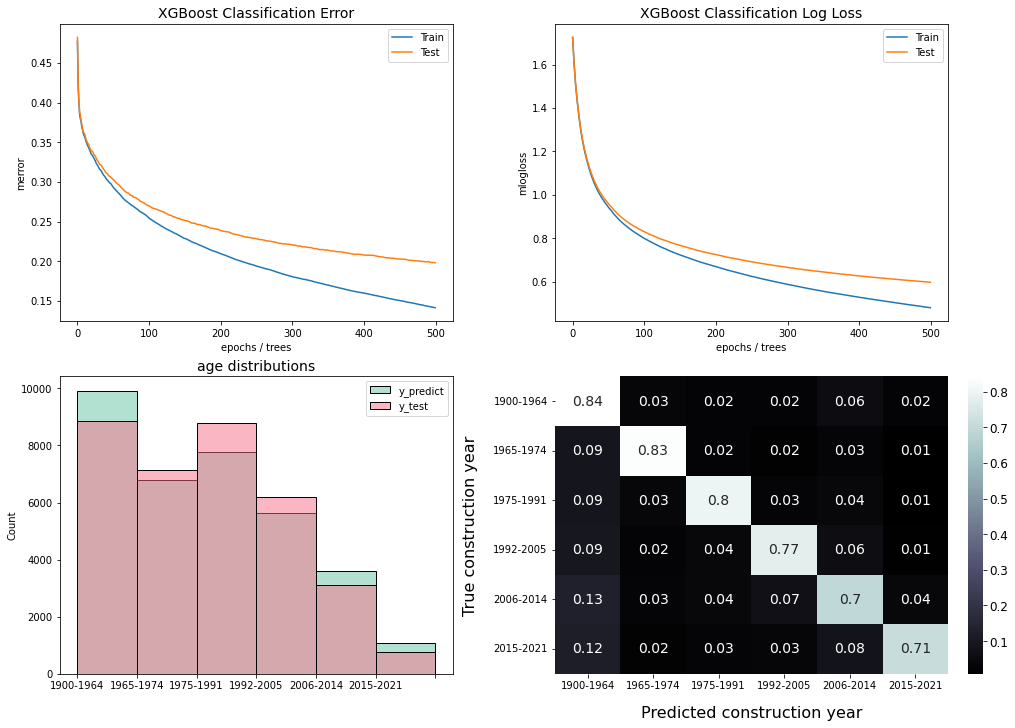

In [18]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = (1900, 2020, 10)

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=tabula_nl_bins,
)
classifier.evaluate()

#### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [34]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2022-10-21 16:42:52,510 | INFO : Starting experiment Spain_random-cv...
2022-10-21 16:42:53,720 | INFO : Dataset length: 974
2022-10-21 16:42:53,726 | INFO : Dataset allocated memory: 1 MB
2022-10-21 16:42:53,731 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-1eb3cae2.abort.
2022-10-21 16:42:53,731 | INFO : Dataset standard deviation: 45.78138305502198
2022-10-21 16:42:53,732 | INFO : Dataset mean age: 1950.3613963039015
2022-10-21 16:42:53,733 | INFO : Training dataset length: 779
2022-10-21 16:42:53,733 | INFO : Test dataset length: 195
2022-10-21 16:42:53,748 | INFO : Test dataset standard deviation after preprocessing: 34.49407581359104
2022-10-21 16:42:53,749 | INFO : Test dataset mean age after preprocessing: 1958.8352272727273
2022-10-21 16:42:53,749 | INFO : Training dataset length after preprocessing: 710
2022-10-21 16:42:53,749 | INFO : Test dataset length after preprocessing: 176
`early_stopping_rounds` in `

In [35]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725
